# Spectrogram Vision Learning using Fastai

## Installation and Setup

In [ ]:
## Install Libraries
# matplotlib provides a wide host of plotting capabilities for data analysis
#!pip install matplotlib

# https://www.fast.ai/
#!pip install fastai

# wget provides Windows and Linux file download compatibility
#!pip install wget

!pip install h5py
!pip install kaggle

The system cannot find the path specified.
The system cannot find the path specified.


In [ ]:
# General Utilities
import warnings
warnings.filterwarnings('ignore')
import os
#import wget
import glob
import shutil 
import tarfile
import h5py

# Machine Learning
from fastai import *
from fastai.vision.all import *

# Imagery Handling
import IPython
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

# Autoreload modules before code execution
%reload_ext autoreload
%autoreload 2
# Plot inline within the notebook
#%matplotlib inline

In [ ]:
dataset_name='g2net-detecting-continuous-gravitational-waves'
display=True
ensemble=3   # Ensemble using the best n models

dir = "E:/data/"
os.chdir(dir)
if os.path.isdir(dir+dataset_name) == False:
    iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
    if iskaggle:
        !pip install -Uqq fastai
    else:
        import zipfile,kaggle
        path = Path(dataset_name)
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

    if iskaggle: path = Path('../input/'+dataset_name)
    if display: path.ls()

In [ ]:
## Utility Function to Check GPU Status
def check_gpu():
    print("CUDA Available: ", torch.cuda.is_available())
    num_devices = torch.cuda.device_count()
    if num_devices > 0:
        for device in range(0,num_devices):
            print("Device", device, "|", torch.cuda.get_device_name(device), 
            "| Allocated:", round(torch.cuda.memory_allocated(device)/1024**3,1), "GB",
            "| Cached:", round(torch.cuda.memory_reserved(device)/1024**3,1), "GB")

#torch.cuda.empty_cache()
check_gpu()

CUDA Available:  True
Device 0 | NVIDIA GeForce GTX 1050 Ti | Allocated: 0.0 GB | Cached: 0.0 GB


## Data Collection and Inspection

In [ ]:
## Define Data Paths and Labels
# Train metadata
di = 'E:/data/g2net-detecting-continuous-gravitational-waves'
df = pd.read_csv(di + '/train_labels.csv')
#df = df[df.target >= 0]  # Remove 3 unknowns (target = -1)

In [ ]:
path = di+'/test/'
listfiles = os.listdir(path)
d= {'id':[file[0:9] for file in listfiles],'target':[0.5 for i in listfiles]}

test_df = pd.DataFrame(data=d)
test_df

,id,target
0,00054c878,0.5
1,0007285a3,0.5
2,00076c5a6,0.5
3,001349290,0.5
4,001a52e92,0.5
5,00222d97b,0.5
6,00249c302,0.5
7,0026862ce,0.5
8,00368b973,0.5
9,003b7a1e9,0.5


In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df):
        self.data_type = data_type
        self.df = df
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64

                p = a.real**2 + a.imag**2  # power
                p /= np.mean(p)  # normalize
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128

                img[ch] = p

        return img, y

In [ ]:
import os
os.mkdir(di+"/output")
os.mkdir(di+"/output/train")
os.mkdir(di+"/output/train/0/")
os.mkdir(di+"/output/train/1/")
os.mkdir(di+"/output/valid")
os.mkdir(di+"/output/valid/0/")
os.mkdir(di+"/output/valid/1/")
os.mkdir(di+"/output/test")

<matplotlib.image.AxesImage>

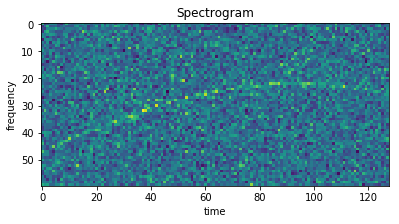

In [ ]:
dataset = Dataset('train', df)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 300:360])  # zooming in for dataset[10]

<matplotlib.image.AxesImage>

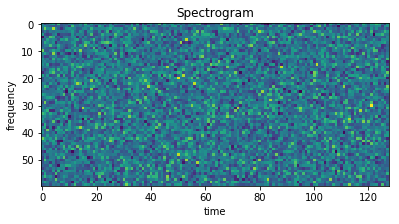

In [ ]:
test_dataset = Dataset('test', test_df)
img, y = test_dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 300:360])  # zooming in for dataset[10]

In [ ]:
def generate_spectrograms(dataset, train_val_split = 0.25, test = False):
    length = len(dataset)
    for i in range(0,length):
        try:
            id_img = dataset.df['id'][i]
            target = dataset.df['target'][i]
            img, y = dataset[i]
        except:
            continue
        if test == True:
            data_type = 'test'
            folder="/"
        else:
            if target == 0:
                folder = "/0/"
            else:
                folder = "/1/"
            if i < np.round((1-train_val_split)*length):
                data_type = "train"
            else:
                data_type = "valid"
        print(i)
        fig = plt.figure(figsize=(8, 3))
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        plt.imshow(img[0])
        image_filepath = di+"/output/"+data_type+folder+str(id_img)+".png"
        print(image_filepath)
        plt.savefig(image_filepath, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [ ]:
generate_spectrograms(dataset)


33
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/1/0ba188c57.png
34
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/1/0bc8216f2.png
35
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/1/0c102ab5a.png
36
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/0/0c30b3fef.png
37
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/0/0c55d030c.png
38
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/1/0d0ad0b19.png
39
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/1/0dc4c8ed0.png
40
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/1/0e39a18bf.png
41
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/0/0e60d4893.png
42
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/0/0e66d0460.png
43
E:/data/g2net-detecting-continuous-gravitational-waves/output/train/0/0eb30f7c4.png
44
E:/data/g2net-detecting-continuous-gravi

In [ ]:
generate_spectrograms(test_dataset, test=True)

0
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/00054c878.png
1
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/0007285a3.png
2
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/00076c5a6.png
3
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/001349290.png
4
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/001a52e92.png
5
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/00222d97b.png
6
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/00249c302.png
7
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/0026862ce.png
8
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/00368b973.png
9
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/003b7a1e9.png
10
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/0040fc1b3.png
11
E:/data/g2net-detecting-continuous-gravitational-waves/output/test/00425c2e7.png
12

## Data Loading and Exploratory Training

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


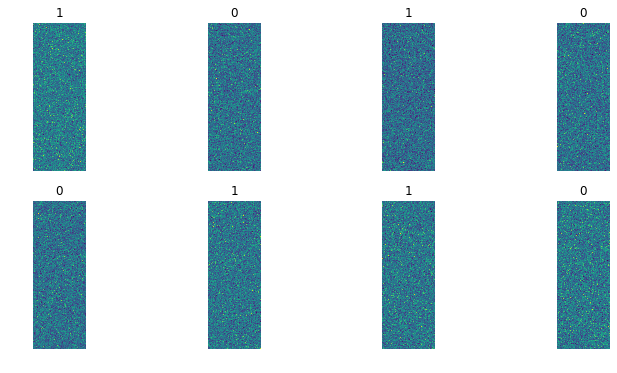

In [ ]:
data_path = di+'/output/'
data = ImageDataLoaders.from_folder(data_path, bs=8)
                                    #item_tfms = Resize(360))
                                    #batch_tfms = [Normalize.from_stats(*imagenet_stats)])
data.show_batch()

SuggestedLRs(valley=0.0010000000474974513)

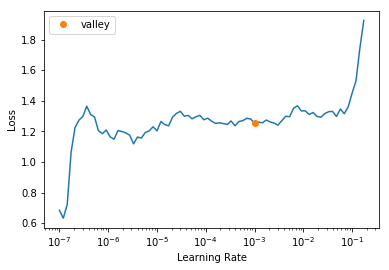

In [ ]:
## Create a Vision Learner (using a CNN under the hood)
# Transfer learning using Resnet
learn = vision_learner(data, resnet34, metrics=accuracy)
learn.lr_find()

In [ ]:
# Set the base Learning Rate
lr = 1E-3

In [ ]:
# Fit one cycle, making sure to avoid overfitting (valid_loss >> train_loss or valid_loss increases)
learn.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.209112,1.175390,0.443709,00:49
1,1.000924,0.975593,0.543046,00:44


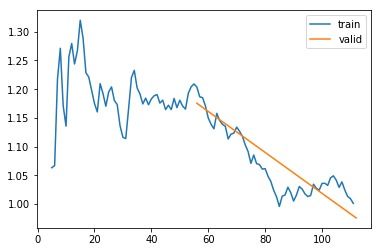

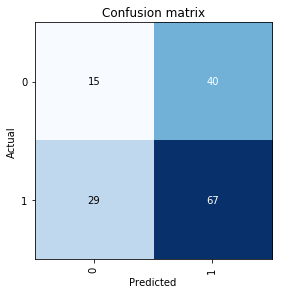

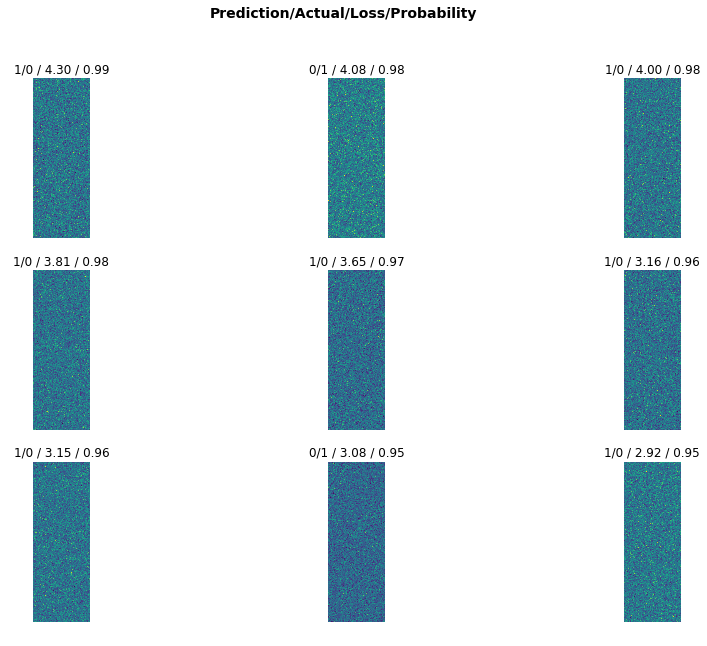

In [ ]:
def interpret(learner):
  learner.recorder.plot_loss()
  interp = ClassificationInterpretation.from_learner(learner)
  interp.plot_confusion_matrix()
  interp.plot_top_losses(9, figsize=(15,10))

interpret(learn)

#### Freezing and Unfreezing the Model
Since we are transfer learning, we may be able to eek out from additional performance by *re-training* part or all of the model layers that are not optimized for this specific type of feature detection. However, this could also lead to overfitting on the training data. See this forum post for some good analogies!

https://forums.fast.ai/t/can-anyone-explain-me-what-does-freeze-and-unfreeze-do/42025

In [ ]:
# Unfreeze to re-train all layers
#learn.unfreeze()

# Freeze_to allows re-training a specified number of layers
learn.freeze_to(-3)
learn.fit_one_cycle(1)
learn.lr_find()

In [ ]:
## Specify lr min and max to progressively get smaller across epochs
lr_min = 1E-6
lr_max = 5E-4

In [ ]:
## Running fit_one_cycle again can improve performance by starting where prior performance left off
learn.fit_one_cycle(2, lr_max=slice(lr_min,lr_max))
interpret(learn)

## Fit the Model for all Folds

In [ ]:
def process(lr, lr_min, lr_max):
    data = ImageDataLoaders.from_folder(data_path, 
                                        #item_tfms = Resize(224),
                                        batch_tfms = [Normalize.from_stats(*imagenet_stats)])
    learn = vision_learner(data, resnet34, metrics=accuracy)
    learn.fit_one_cycle(2, lr)
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, lr)
    learn.fit_one_cycle(2, lr_max=slice(lr_min,lr_max))
    return learn

In [ ]:
preds = learn.predict(test_df)

In [ ]:
def subm(df, dep, preds):
    df[dep] = preds
    sub_df = df
    sub_df.to_csv(f'submission.csv', index=False)

subm(test_df, 'target', preds)